In [4]:
import tensorflow as tf
keras = tf.keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#data loading
train_dir = r'C:\ML\Facial-Expression-Recognition\data\expression_dataset\train'
val_dir = r'C:\ML\Facial-Expression-Recognition\data\expression_dataset\validation'

In [6]:
batch_size = 32
img_height = 160
img_width = 160

train_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:
for image, labels in train_ds:
    print(image.shape)
    print(labels.shape)
    break

(32, 160, 160, 3)
(32,)


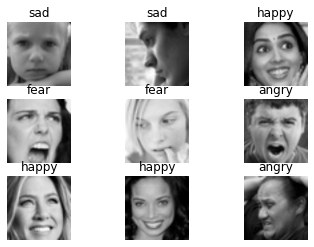

In [9]:
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
#use buffered prefetching so you can yield data from disk without having I/O become blocking.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
#The RGB channel values are in the [0, 255] range
#standardizing values to be in the [0, 1]
normalization_layer = keras.layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#print(first_image)
# check the pixel values
print(np.min(first_image), np.max(first_image))

0.0 0.29692158


In [15]:
num_classes = 7

model = keras.Sequential([
  #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model = model.fit(
  normalized_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
901/901 [==============================] - 148s 163ms/step - loss: 1.6360 - accuracy: 0.3553 - val_loss: 1.5046 - val_accuracy: 0.4243
Epoch 2/10
901/901 [==============================] - 153s 169ms/step - loss: 1.3697 - accuracy: 0.4735 - val_loss: 1.3780 - val_accuracy: 0.4751
Epoch 3/10
901/901 [==============================] - 151s 168ms/step - loss: 1.2118 - accuracy: 0.5409 - val_loss: 1.3093 - val_accuracy: 0.5034
Epoch 4/10
901/901 [==============================] - 156s 173ms/step - loss: 1.0577 - accuracy: 0.6033 - val_loss: 1.3355 - val_accuracy: 0.5086
Epoch 5/10
901/901 [==============================] - 158s 175ms/step - loss: 0.8900 - accuracy: 0.6692 - val_loss: 1.3947 - val_accuracy: 0.5241
Epoch 6/10
901/901 [==============================] - 150s 167ms/step - loss: 0.6946 - accuracy: 0.7469 - val_loss: 1.5839 - val_accuracy: 0.5051
Epoch 7/10
901/901 [==============================] - 150s 166ms/step - loss: 0.5168 - accuracy: 0.8136 - val_loss: 1.8250 -

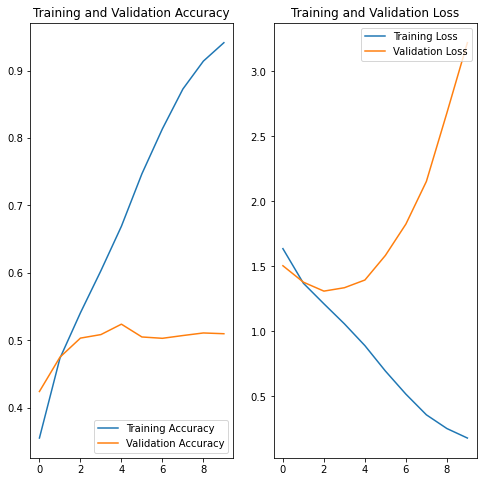

In [18]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']

loss = model.history['loss']
val_loss = model.history['val_loss']

epochs_range = range(10) #no. of epochs which is 10

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
  ]
)

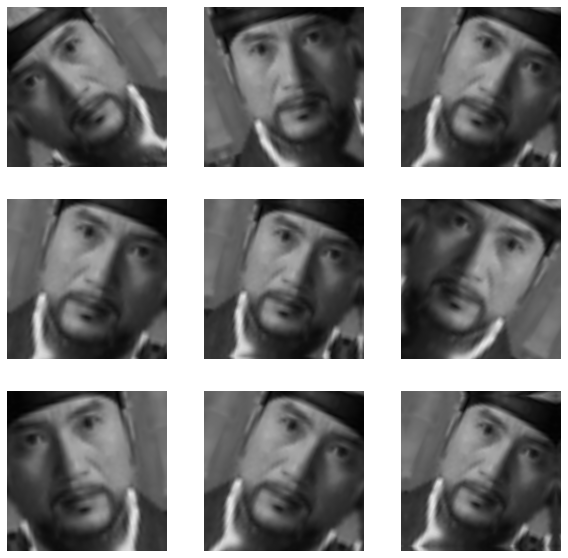

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
new_model = keras.Sequential([
  data_augmentation,
  #layers.Rescaling(1./255),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])
new_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 64)       

In [23]:
epochs = 15
aug_model = new_model.fit(
  normalized_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
901/901 [==============================] - 177s 196ms/step - loss: 1.7596 - accuracy: 0.2806 - val_loss: 1.6592 - val_accuracy: 0.3457
Epoch 2/15
901/901 [==============================] - 180s 199ms/step - loss: 1.6437 - accuracy: 0.3496 - val_loss: 1.5439 - val_accuracy: 0.4045
Epoch 3/15
901/901 [==============================] - 178s 198ms/step - loss: 1.5536 - accuracy: 0.3937 - val_loss: 1.4618 - val_accuracy: 0.4373
Epoch 4/15
901/901 [==============================] - 174s 194ms/step - loss: 1.4996 - accuracy: 0.4200 - val_loss: 1.4306 - val_accuracy: 0.4516
Epoch 5/15
901/901 [==============================] - 173s 192ms/step - loss: 1.4636 - accuracy: 0.4300 - val_loss: 1.4257 - val_accuracy: 0.4588
Epoch 6/15
901/901 [==============================] - 173s 192ms/step - loss: 1.4322 - accuracy: 0.4442 - val_loss: 1.3657 - val_accuracy: 0.4716
Epoch 7/15
901/901 [==============================] - 550s 611ms/step - loss: 1.4103 - accuracy: 0.4541 - val_loss: 1.3430 -

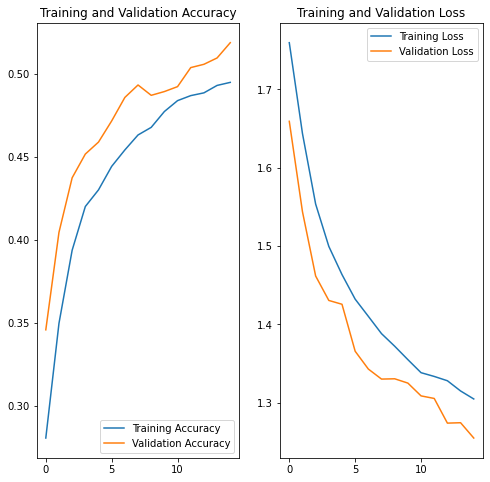

In [24]:
acc = aug_model.history['accuracy']
val_acc = aug_model.history['val_accuracy']

loss = aug_model.history['loss']
val_loss = aug_model.history['val_loss']

epochs_range = range(15) #no. of epochs which is 10

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
unseen_img = r'ang.jpg'
img = tf.keras.utils.load_img(
    unseen_img, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255
#print(img_array)
predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to angry with a 31.40 percent confidence.
